<a href="https://colab.research.google.com/github/stodar/Algorithmic-Trading-Strategy/blob/main/Algorithmic_Trading_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an Algorithmic Trading Strategy using Reinforcement Learning

## Source : [Link](https://medium.com/@tomydinero27/building-an-algorithmic-trading-strategy-using-reinforcement-learning-4ab12488d190)

Nous avons exploré comment construire une stratégie de trading algorithmique en utilisant l'apprentissage par renforcement en Python. Nous avons commencé par acquérir des données de prix historiques à l'aide de la bibliothèque yfinance, puis nous avons prétraité les données pour les préparer à la formation. Nous avons ensuite construit un modèle d'apprentissage par renforcement à l'aide de l'algorithme d'optimisation de la politique proximale (PPO) et nous l'avons formé sur les données de formation. Enfin, nous avons évalué la performance de notre stratégie de trading sur les données de test et visualisé les résultats.

En tirant parti du pouvoir de l'apprentissage par renforcement, nous pouvons développer des stratégies de trading qui s'adaptent à l'évolution des conditions du marché et apprennent des expériences passées. Cela ouvre de nouvelles possibilités aux traders de prendre des décisions éclairées et potentiellement d'améliorer leurs performances de négociation.

N'oubliez pas que la mise en place d'une stratégie de négociation réussie nécessite un examen attentif de divers facteurs, y compris la gestion des risques, la dynamique du marché et les coûts de négociation. Il est important de tester et de valider minutieusement toute stratégie de trading avant de la déployer dans un environnement de trading en direct.



---



In [15]:
import yfinance as yf
import numpy as np
import pandas as pd

## Step 1: Data Acquisition

In [3]:
# Define the ticker symbol
ticker = "AAPL"

In [4]:
# Download the historical price data
data = yf.download(ticker, start="2018-01-01", end="2023-10-31")

[*********************100%%**********************]  1 of 1 completed


In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.776520,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.769417,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,40.958797,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.425121,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.271255,82271200


In [13]:
data.shape

(1456, 6)

## Step 2: Data Preprocessing

In [7]:
# Remove missing values from the data
data = data.dropna()

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [12]:
data_normalized.shape

(1456, 6)

In [16]:
# Convert data_normalized into a pandas DataFrame
data = pd.DataFrame(data_normalized, columns=data.columns)

In [17]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [19]:
train_data.shape , test_data.shape

((1164, 6), (292, 6))

## Step 3: Building the Reinforcement Learning Model

**Information :**

- le Proximal Policy Optimization est une méthode d'apprentissage par renforcement qui vise à améliorer la politique d'un agent de manière incrémentielle tout en évitant des mises à jour de politique trop agressives. Cela en fait un choix populaire pour l'entraînement d'agents d'IA dans des environnements complexes et dynamiques.



- Pour mettre en œuvre l'algorithme PPO, nous utiliserons la bibliothèque `stable-baselines3`, qui fournit une interface de haut niveau pour la formation et l'évaluation des modèles d'apprentissage par renforcement.

In [31]:
!pip install stable-baselines3[extra] &>/dev/null # &>/dev/null --> hide output

In [35]:
!pip install gym &>/dev/null

In [45]:
!pip install pyglet &>/dev/null

In [40]:
import sys
sys.path.append('/home/jupyter/.local/lib/python3.10/site-packages')

In [100]:
from stable_baselines3 import PPO
#from stable_baselines3.common.envs import DummyVecEnv
from stable_baselines3.common.vec_env import DummyVecEnv
import gym

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
# Define the trading environment
class TradingEnvironment(gym.Env):
    def __init__(self, data):
        self.data = data
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(len(data.columns),))

    def reset(self):
        self.current_step = 0
        self.account_balance = 100000  # Initial account balance
        self.shares_held = 0
        self.net_worth = self.account_balance
        self.max_net_worth = self.account_balance

        return self._next_observation()

    def _next_observation(self):
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        if self.current_step > len(self.data) - 1:
            self.current_step = 0

        return self._next_observation(), self._get_reward(), self.net_worth, {}

    def _take_action(self, action):
        if action == 0:  # Buy
            self.shares_held += self.account_balance / self.data.iloc[self.current_step].values[0]
            self.account_balance -= self.account_balance
        elif action == 1:  # Sell
            self.account_balance += self.shares_held * self.data.iloc[self.current_step].values[0]
            self.shares_held -= self.shares_held

        self.net_worth = self.account_balance + self.shares_held * self.data.iloc[self.current_step].values[0]

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

    def _get_reward(self):
        return self.net_worth - self.account_balance

# Create the trading environment
env = TradingEnvironment(train_data)

**Explication :**

Le code que vous avez fourni est un script Python qui définit un environnement de trading personnalisé destiné à être utilisé dans l'apprentissage par renforcement avec la bibliothèque Stable Baselines3. Il crée également une instance de cet environnement personnalisé appelée "env". Voici une explication du code par sections :

1. **Instructions d'importation** :
   - Le script commence par importer les bibliothèques nécessaires de Stable Baselines3 (`PPO`) et de Gym (`gym`) pour l'apprentissage par renforcement.
   - `DummyVecEnv` est importé pour envelopper l'environnement en tant qu'environnement vectorisé, ce qui est souvent utilisé avec les algorithmes d'apprentissage par renforcement.

2. **Définition de l'environnement de trading** :
   - Un environnement de trading personnalisé est défini, qui est une sous-classe de `gym.Env`.
   - Dans le constructeur `__init__`, l'environnement est initialisé avec un jeu de données `data` représentant des données financières.
   - `action_space` définit les actions possibles qu'un agent peut entreprendre : Acheter, Vendre ou Rester (Hold). Il est défini comme un espace discret avec 3 actions.
   - `observation_space` définit l'espace des observations. Il est défini comme un espace continu avec des valeurs entre 0 et 1, avec une forme correspondant au nombre de colonnes dans les données.

3. **Méthode de réinitialisation (reset)** :
   - La méthode `reset` est appelée pour réinitialiser l'état de l'environnement aux conditions initiales.
   - Le solde du compte de l'agent, les actions détenues, la valeur nette et la valeur nette maximale sont initialisés.
   - Elle renvoie l'observation initiale en utilisant `_next_observation()`.

4. **Méthode `_next_observation`** :
   - La méthode `_next_observation` renvoie l'observation pour l'instant courant, qui correspond simplement aux données financières à cet instant.

5. **Méthode `step`** :
   - La méthode `step` est appelée lorsque l'agent prend une action.
   - Elle prend l'action en entrée, met à jour l'état de l'environnement avec `_take_action(action)`, avance d'un pas de temps et renvoie :
     - La prochaine observation.
     - La récompense, calculée à l'aide de `_get_reward()`.
     - La nouvelle valeur nette.
     - Un dictionnaire vide, une pratique courante dans les environnements Gym pour renvoyer des informations supplémentaires (non utilisé ici).

6. **Méthode `_take_action`** :
   - La méthode `_take_action` met à jour l'état de l'environnement en fonction de l'action choisie.
   - Si l'action est d'acheter (action 0), elle calcule le nombre d'actions que l'agent peut acheter et met à jour le solde du compte et les actions détenues en conséquence.
   - Si l'action est de vendre (action 1), elle calcule les produits de la vente de toutes les actions détenues et met à jour le solde du compte et les actions détenues.
   - La valeur nette est mise à jour en conséquence, et si elle atteint un nouveau maximum, `max_net_worth` est mis à jour.

7. **Méthode `_get_reward`** :
   - `_get_reward` calcule la récompense de l'agent, qui correspond à la variation de la valeur nette par rapport au solde du compte initial.

8. **Création de l'environnement de trading** :
   - Après avoir défini l'environnement de trading personnalisé, une instance de cet environnement (`env`) est créée et initialisée avec `train_data`.

Cet environnement personnalisé est conçu pour permettre aux agents d'apprentissage par renforcement d'apprendre comment prendre des décisions de trading sur le marché financier en fonction des données fournies. Il fournit des observations, des actions et des récompenses pour faciliter la formation des agents d'apprentissage par renforcement à l'aide d'algorithmes tels que PPO.

In [125]:
# Initialize the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=50000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 3.3e+04  |
| time/              |          |
|    fps             | 908      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1             |
|    ep_rew_mean          | 3.4e+04       |
| time/                   |               |
|    fps                  | 680           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 6.0165563e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 0             |


## Step 4: Evaluating the Trading Strategy

Commençons par définir une fonction pour simuler la stratégie de trading.

In [126]:
monvar = []
def simulate_trading_strategy(model, data):
    global monvar
    env = TradingEnvironment(data)
    obs = env.reset()

    for i in range(len(data)):
        action, _ = model.predict(obs)
        obs, _, _, _ = env.step(action)
        monvar.append(env.net_worth)

    return env.net_worth

In [127]:
# Simulate the trading strategy on the testing data
net_worth = simulate_trading_strategy(model, test_data)

## Step 5: Visualizing the Results


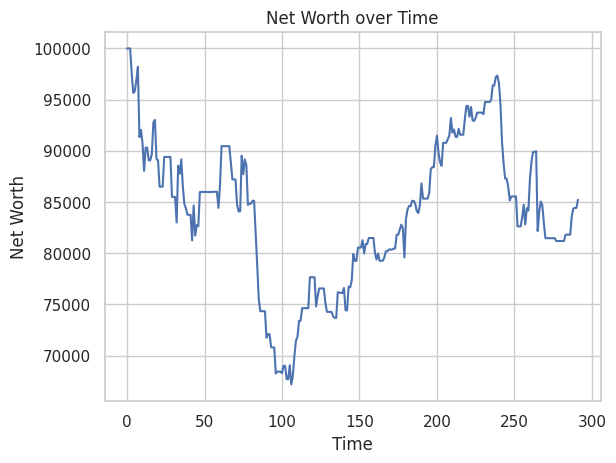

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the net worth over time
plt.plot(monvar)
plt.xlabel("Time")
plt.ylabel("Net Worth")
plt.title("Net Worth over Time")
plt.show()